In [1]:
# Code for analyzing NFL big data bowl data (probably with Celia!!!)

In [221]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import nflDataFunctions as nfldf

pd.set_option('display.max_rows', 50)

In [386]:
# Check if the abbreviated names have a 1-1 correspondence with the full names
# ----- it's not perfect because the abbreviated names are subject to variation and my string detection isn't perfect. most are good though...

In [7]:
games, players, plays, pffData = nfldf.loadData()
weekData = nfldf.loadWeek()

In [88]:
playWeek = nfldf.playWeek(games, plays)

In [294]:
# Code to identify target Receiver
itrOutputs = nfldf.identifyTargetReceiver(weekData[0],plays,playWeek,weekId=1)
receiverName, descName, receiverDistance, receiverNextClosestDistance, qbNflId = itrOutputs

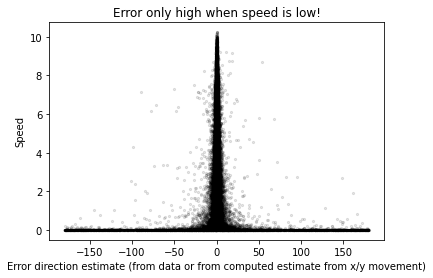

In [346]:
# Collect movement data for target receivers on each play
rvcOutputs = nfldf.receiverVelocityCheck(weekData[0],plays,playWeek,weekId=1)
dx, dy, speed, direction = rvcOutputs

In [387]:
# next step-- measure relationship between location of ball being caught by receiver and expected location given speed and direction and previous location 
# I guess I should pick a certain timing? 

In [ ]:
# Code to identify unique abbreviations in play descriptions of plays resulting in completions
uniqAbbreviations = nfldf.checkAbbreviatedNames(plays)
# for abb in uniqAbbreviations: print(abb)

In [301]:
# Showing some plays where the two closest receivers were a similar distance from the football
fsDiff = receiverNextClosestDistance-receiverDistance
idxCloseSecond = np.where(fsDiff<2)[0]
for idx in idxCloseSecond:
    print(f"idx: {idx} Target receiver: {receiverName[idx]}, descName: {descName[idx]}")

idx: 31 Target receiver: Mohamed Sanu, descName: M.Sanu
idx: 51 Target receiver: Jarvis Landry, descName: J.Landry
idx: 93 Target receiver: T.Y. Hilton, descName: T.Hilton
idx: 119 Target receiver: Tyler Boyd, descName: T.Boyd
idx: 227 Target receiver: DeAndre Hopkins, descName: D.Hopkins
idx: 252 Target receiver: Ryan Griffin, descName: D.Hopkins
idx: 362 Target receiver: Larry Fitzgerald, descName: L.Fitzgerald
idx: 390 Target receiver: David Johnson, descName: D.Johnson
idx: 433 Target receiver: Taylor Gabriel, descName: T.Gabriel
idx: 451 Target receiver: Anthony Miller, descName: A.Miller
idx: 530 Target receiver: Todd Gurley, descName: T.Gurley
